In [6]:
import pandas as pd
import numpy as np
import random
from datetime import timedelta

# Example function to generate synthetic headlines
def generate_headlines(symbol, start_date, end_date, n=120):
    date_range = pd.date_range(start=start_date, end=end_date)
    headlines = []
    for _ in range(n):
        date = random.choice(date_range)
        sentiment = random.choice(["positive", "negative", "neutral"])
        if sentiment == "positive":
            headline = f"{symbol} stock surges after strong earnings report"
        elif sentiment == "negative":
            headline = f"{symbol} shares fall on regulatory concerns"
        else:
            headline = f"{symbol} stock shows little movement today"
        headlines.append({"date": date, "headline": headline})
    df = pd.DataFrame(headlines)
    return df

# Generate and save CSVs
for symbol in STOCKS:
    df_news = generate_headlines(symbol, "2024-01-01", "2024-06-30")  # Replace with actual min/max from Step 1
    df_news.to_csv(f"{news_dir}{symbol}_news.csv", index=False)


In [ ]:
# -------------------------------
# Task 3: Stock + News Analysis
# -------------------------------
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
import os

# -------------------------------
# Paths and Stock Symbols
# -------------------------------
DATA_PATH = "./data/raw/"       # your stock CSVs
NEWS_PATH = "./data/raw/news/"  # your news CSVs
STOCKS = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA"]

# -------------------------------
# Step 1: Load Stock Data (2024 only)
# -------------------------------
def load_stock(symbol):
    df = pd.read_csv(os.path.join(DATA_PATH, f"{symbol}.csv"))
    df["Date"] = pd.to_datetime(df["Date"])
    # Filter to 2024 for overlap with news
    df = df[df["Date"].dt.year == 2024].reset_index(drop=True)
    df["stock"] = symbol
    return df

prices = {symbol: load_stock(symbol) for symbol in STOCKS}
prices_df = pd.concat(prices.values(), ignore_index=True)

# -------------------------------
# Step 2: Load News Data
# -------------------------------
def load_news(symbol):
    df = pd.read_csv(os.path.join(NEWS_PATH, f"{symbol}_news.csv"))
    df["date"] = pd.to_datetime(df["date"])
    df["headline"] = df["headline"].astype(str)
    df["stock"] = symbol
    return df

news_data = {symbol: load_news(symbol) for symbol in STOCKS}
news_df = pd.concat(news_data.values(), ignore_index=True)

# -------------------------------
# Step 3: Compute Sentiment (VADER)
# -------------------------------
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return pd.Series(scores)

sentiment_scores = news_df["headline"].apply(analyze_sentiment)
news_df = pd.concat([news_df, sentiment_scores], axis=1)

# -------------------------------
# Step 4: Compute Daily Mean Sentiment
# -------------------------------
daily_sentiment = news_df.groupby(["stock", "date"])[["compound", "pos", "neg", "neu"]].mean().reset_index()
daily_sentiment.rename(columns={"pos":"positive","neg":"negative","neu":"neutral"}, inplace=True)

# -------------------------------
# Step 5: Merge Stock + Daily Sentiment
# -------------------------------
merged_data = []
for symbol in STOCKS:
    stock_df = prices_df[prices_df["stock"] == symbol].copy()
    sentiment_df = daily_sentiment[daily_sentiment["stock"] == symbol].copy()
    merged = pd.merge(stock_df, sentiment_df, left_on="Date", right_on="date", how="left")
    merged_data.append(merged)

merged_df = pd.concat(merged_data, ignore_index=True)

# -------------------------------
# Step 6: Compute Returns
# -------------------------------
merged_df["daily_return"] = merged_df.groupby("stock")["Close"].pct_change()
merged_df["return_next_1d"] = merged_df.groupby("stock")["daily_return"].shift(-1)
merged_df["return_next_3d"] = merged_df.groupby("stock")["Close"].pct_change(3).shift(-3)

# -------------------------------
# Step 7: Run Regression
# -------------------------------
df_clean = merged_df.dropna(subset=["return_next_1d", "compound", "daily_return"])
if not df_clean.empty:
    X = df_clean[["compound", "positive", "negative", "neutral"]]
    X = sm.add_constant(X)
    y = df_clean["return_next_1d"]
    
    model = sm.OLS(y, X).fit()
    print(model.summary())
else:
    print("No data available for regression. Check merged_df and df_clean.")

# -------------------------------
# Step 8: Save Merged Data
# -------------------------------
merged_df.to_csv("merged_stock_news_2024.csv", index=False)
print("Merged data saved to merged_stock_news_2024.csv")


AAPL stock: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
AMZN stock: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
GOOG stock: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
META stock: 2012-05-18 00:00:00 to 2023-12-29 00:00:00
MSFT stock: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
NVDA stock: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
AAPL news: 2024-01-05 00:00:00 to 2024-06-29 00:00:00
AMZN news: 2024-01-01 00:00:00 to 2024-06-27 00:00:00
GOOG news: 2024-01-06 00:00:00 to 2024-06-29 00:00:00
META news: 2024-01-02 00:00:00 to 2024-06-26 00:00:00
MSFT news: 2024-01-02 00:00:00 to 2024-06-30 00:00:00
NVDA news: 2024-01-06 00:00:00 to 2024-06-27 00:00:00


Correlation matrix:
                 mean_sentiment  daily_return  return_next_1d
mean_sentiment             NaN           NaN             NaN
daily_return               NaN      1.000000       -0.039681
return_next_1d             NaN     -0.039681        1.000000


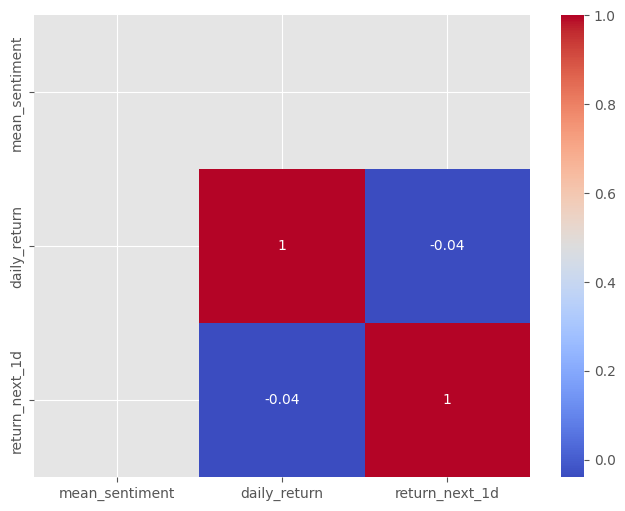

No data available for regression. Check merged_df and df_clean.
Merged data saved successfully.


In [26]:
# -------------------------------
# Task 3: Stock-News Sentiment Analysis
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# -------------------------------
# Step 0: Define paths & stocks
# -------------------------------
DATA_PATH = "../data/raw/"
NEWS_PATH = "../data/raw/news/"
STOCKS = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA"]

# -------------------------------
# Step 1: Load stock data
# -------------------------------
def load_stock(symbol):
    df = pd.read_csv(f"{DATA_PATH}{symbol}.csv")
    # Stock CSV uses 'Date'
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
    df["stock"] = symbol
    return df

prices = {symbol: load_stock(symbol) for symbol in STOCKS}

# -------------------------------
# Step 2: Load news data
# -------------------------------
def load_news(symbol):
    df = pd.read_csv(f"{NEWS_PATH}{symbol}_news.csv")
    df["date"] = pd.to_datetime(df["date"])
    df["headline"] = df["headline"].astype(str)
    df["stock"] = symbol
    return df

news_data = {symbol: load_news(symbol) for symbol in STOCKS}
news_df = pd.concat(news_data.values(), ignore_index=True)

# -------------------------------
# Step 3: Sentiment Analysis (VADER)
# -------------------------------
analyzer = SentimentIntensityAnalyzer()

for col in ["compound", "pos", "neg", "neu"]:
    news_df[col] = news_df["headline"].apply(lambda x: analyzer.polarity_scores(x)[col if col != "pos" else "pos"])

# -------------------------------
# Step 4: Aggregate daily sentiment
# -------------------------------
daily_sentiment = news_df.groupby(["stock", "date"])[["compound", "pos", "neg", "neu"]].mean().reset_index()
daily_sentiment.rename(columns={"pos":"positive", "neg":"negative", "neu":"neutral"}, inplace=True)

# -------------------------------
# Step 5: Merge stock and sentiment data
# -------------------------------
# Merge and ensure 'stock' exists
merged_data = {}
for symbol in STOCKS:
    stock_df = prices[symbol]
    sentiment_df = daily_sentiment[daily_sentiment["stock"] == symbol]
    
    merged = pd.merge(
        stock_df,
        sentiment_df,
        left_on="Date",
        right_on="date",
        how="left",
        suffixes=('_stock', '_news')
    )
    
    # Make sure 'stock' column exists
    merged["stock"] = symbol
    
    merged_data[symbol] = merged

merged_df = pd.concat(merged_data.values(), ignore_index=True)


# -------------------------------
# Step 6: Compute daily returns & next-day returns
# -------------------------------
merged_df["daily_return"] = merged_df.groupby("stock")["Close"].pct_change()
merged_df["return_next_1d"] = merged_df.groupby("stock")["daily_return"].shift(-1)
merged_df["return_next_3d"] = merged_df.groupby("stock")["Close"].pct_change(3).shift(-3)

# -------------------------------
# Step 7: Add mean_sentiment column
# -------------------------------
merged_df["mean_sentiment"] = merged_df["compound"]  # use compound as the main sentiment score

# -------------------------------
# Step 8: Correlation Analysis
# -------------------------------
correlation_cols = ["mean_sentiment", "daily_return", "return_next_1d"]
corr = merged_df[correlation_cols].corr()
print("Correlation matrix:\n", corr)

# Optional: visualize correlation
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

# -------------------------------
# Step 9: Regression Analysis
# -------------------------------
df_clean = merged_df.dropna(subset=["return_next_1d", "mean_sentiment", "daily_return"])
if not df_clean.empty:
    X = df_clean[["compound", "positive", "negative", "neutral"]]
    X = sm.add_constant(X)
    y = df_clean["return_next_1d"]
    
    model = sm.OLS(y, X).fit()
    print(model.summary())
else:
    print("No data available for regression. Check merged_df and df_clean.")

# -------------------------------
# Step 10: Save merged data
# -------------------------------
merged_df.to_csv("../data/processed/merged_stock_news.csv", index=False)
print("Merged data saved successfully.")
